In [69]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.decomposition import TruncatedSVD,PCA
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score, mean_squared_error,accuracy_score,v_measure_score, silhouette_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold,train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


In [2]:
file_object = open('clean_data.p', 'rb')
clean_data = pickle.load(file_object)
train = clean_data[0]
test = clean_data[1]
train.head(3)

,comment_text,non_toxic,mild_toxicity,toxic,severe_toxic,toxicity_level
0,sorry break unsourced film plot much error uns...,1,0,0,0,1
1,criticism criticism doesnt belong title busine...,1,0,0,0,1
2,article cant remember password jim bakken im f...,1,0,0,0,1


In [3]:
train['toxicity_level'].value_counts()

4    1595
1    1433
3    1370
2     931
Name: toxicity_level, dtype: int64

In [7]:
def topNwords(data,topN=5):
    vec= CountVectorizer(stop_words='english',analyzer='word').fit(data)
    bagOfW= vec.transform(data)
    sumWord= bagOfW.sum(axis=0)
    wordFreq= [(word,sumWord[0,idx])for word, idx in vec.vocabulary_.items()]
    wordFreq= sorted(wordFreq,key=lambda x:x[1], reverse=True)
    topTerm= pd.DataFrame(wordFreq[:topN], columns=["Term","Count"])
    return topTerm

def topTermByClass(data, topN=10):
    ''' Expecting the data with two columns, one with comment_text, the other
    with its toxicity_level. Return a list of dataframes for each of the class in the toxicity_level,
    where each dataframe contains topN terms and their tfidf value'''
    dfs=[]
    for level in np.unique(data['toxicity_level']):
        idx= data['toxicity_level'].index[data['toxicity_level']==level]
        topTerm= topNwords(data.loc[idx]['comment_text'],topN= 10)
        dfs.append(topTerm)
    type=['non_toxic','mild_toxicity','toxic','severe_toxic']
    plt.figure(figsize=(10,8))
    plt.suptitle("Top Terms/Toxicity Level",fontsize=10)
    plt.rcParams["figure.autolayout"] = True
    gridspec.GridSpec(2,2)
    for termClass in range(2):
        plt.subplot2grid((2,2),(0,termClass))
        sns.barplot(x=dfs[termClass]['Term'],y=dfs[termClass]['Count'])
        plt.title((f"Toxicity Class:{type[termClass]}"),fontsize=8)
        plt.xlabel('Word', fontsize=7)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)
        plt.ylabel('Count', fontsize=7)
    row2Ind= 2
    for row2 in range(2):
        plt.subplot2grid((2,2),(1,row2))
        sns.barplot(x=dfs[row2Ind]['Term'],y=dfs[row2Ind]['Count'])
        plt.title((f"Toxicity Class:{type[row2Ind]}"),fontsize=8)
        plt.xlabel('Word', fontsize=7)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)
        plt.ylabel('Count', fontsize=7)
        row2Ind +=1
    plt.show()
    return dfs

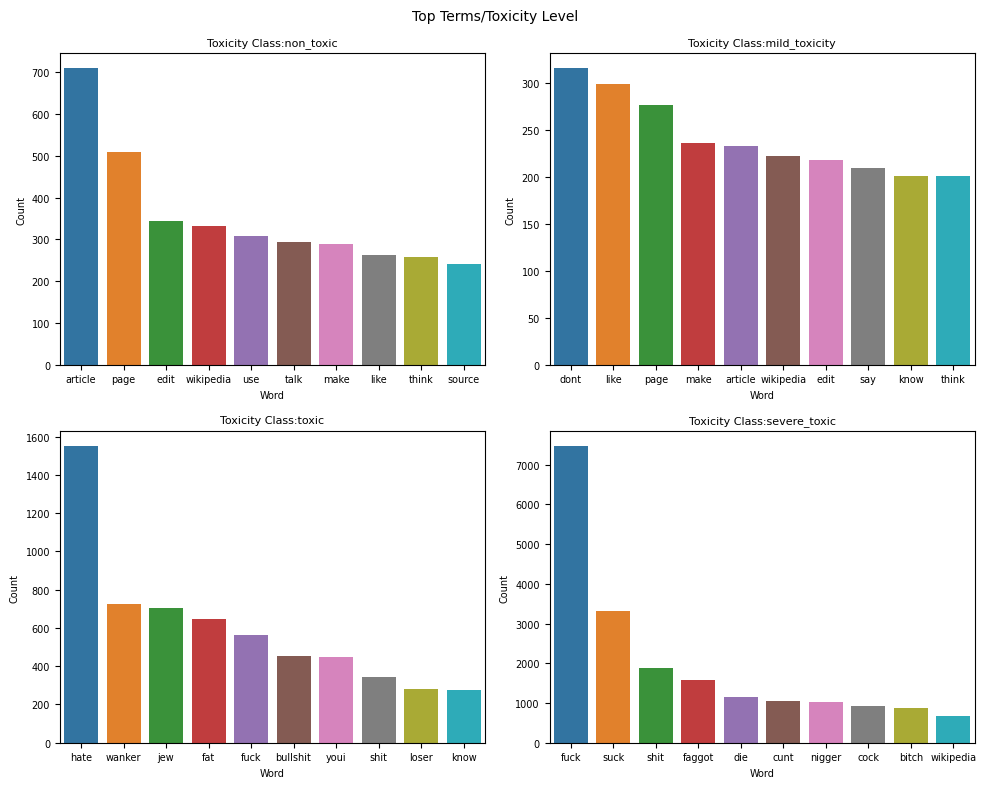

In [8]:
trainSub= train[['comment_text','toxicity_level']]
x= topTermByClass(trainSub,10)

In [9]:
def TFIDF_func(data):
    vectorizer= TfidfVectorizer(smooth_idf=True, sublinear_tf=False, norm=None, 
                         analyzer='word')
    txt_fitted= vectorizer.fit(data)
    txt_tranformed = txt_fitted.transform(data) 
    X_tfidf= txt_tranformed.toarray()
    terms= np.array(txt_fitted.get_feature_names_out())   
    return X_tfidf, terms

X_tfidf, terms= TFIDF_func(train['comment_text'])
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
# LSA and Plot for Cumulative_explained_variance vs n_componenets
def LSA(X, list_comp): 
    EVar=[] 
    for n_comp in list_comp:
        lsa= make_pipeline(TruncatedSVD(n_components=n_comp), 
                           Normalizer(copy=False))
        lsa.fit(X)
        explainedVar = lsa[0].explained_variance_ratio_.sum()
        EVar.append(explainedVar)
        print("Number of components = %r and explained variance = %r"%(n_comp,explainedVar))
    plt.plot(list_comp,EVar, linewidth=2)
    plt.xlabel('n_components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title("Cumulative Explained Variance VS N_components")
    plt.show()

Number of components = 184 and explained variance = 0.9881044234451991
Number of components = 174 and explained variance = 0.9876779235897885
Number of components = 164 and explained variance = 0.9871816487434819
Number of components = 154 and explained variance = 0.9866181454633509
Number of components = 144 and explained variance = 0.985916252412692
Number of components = 134 and explained variance = 0.9849988201357818
Number of components = 124 and explained variance = 0.9836695368174649
Number of components = 114 and explained variance = 0.9815518705742265
Number of components = 104 and explained variance = 0.9774338533088875
Number of components = 94 and explained variance = 0.9704441075129507
Number of components = 84 and explained variance = 0.9581248527139719
Number of components = 74 and explained variance = 0.9408841549010544
Number of components = 64 and explained variance = 0.9162387165400174
Number of components = 54 and explained variance = 0.8832377865787848
Number of co

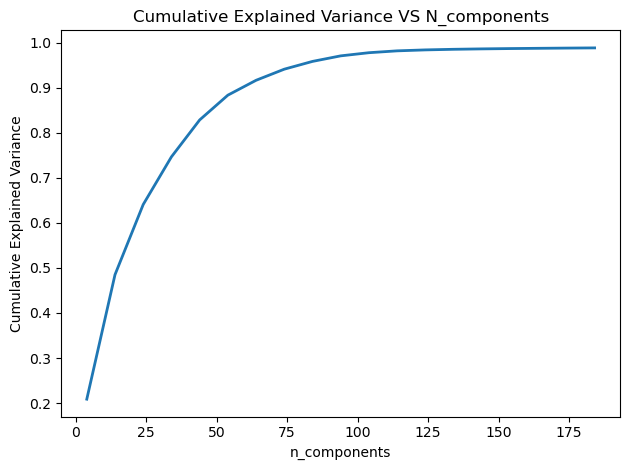

In [25]:
step=10
column= X_tfidf.shape[1]
LSA(X_tfidf,range(column-(1770*step),0,-step))

## Question to explore: Will tsvd perform differently on diff algothrim?

In [36]:

skf= StratifiedKFold(n_splits=5,shuffle=True,random_state=961)
w=[]
#loop through the value for svd dimension parameter
for n in range(115,105,-1): #negative step to let range decrease from start
    log=[]
    for train_index, test_index in skf.split(X_tfidf,train['toxicity_level']):
        xTrain, xTest= X_tfidf[train_index,:],X_tfidf[test_index,:]
        yTrain,yTest= train['toxicity_level'][train_index],train['toxicity_level'][test_index]
        lsa= make_pipeline(TruncatedSVD(n_components=n), Normalizer(copy=False))
        xTrain_lsa= lsa.fit_transform(xTrain)
        xTest_lsa= lsa.transform(xTest)    
        sdg_params = { 
            'loss': ['log','hinge','modified_huber'], 
            'penalty': ['l2','elasticnet'],
            "alpha" : [0.0001, 0.001, 0.01, 0.1],
            'n_jobs': [-1]
            }
        model= SGDClassifier(max_iter= 3000,random_state=961)
        grid= GridSearchCV(model, param_grid=sdg_params,cv=5)
        grid.fit(xTrain_lsa,yTrain)
        #model= LogisticRegression(solver='lbfgs',multi_class="multinomial").fit(xTrain_lsa,yTrain)

        BModel= SGDClassifier(**grid.best_params_, max_iter= 3000,random_state=961)
        BModel.fit(xTrain_lsa,yTrain)

        f1Train= f1_score(yTrain,BModel.predict(xTrain_lsa),average='micro')
        f1Test= f1_score(yTest,BModel.predict(xTest_lsa),average='micro') 
        AccTest= accuracy_score(yTest,BModel.predict(xTest_lsa))
        log.append([f1Train,f1Test,AccTest])
    print("For n_component= %r ,the best parameters are: %r"%(n, grid.best_params_))
    
    mean= np.mean(log,axis=0)
    F1_train= mean[0]
    F1_test= mean[1]
    Accu_Test= mean[2]

    w.append([n,F1_train, F1_test, Accu_Test])  
svd_dm= pd.DataFrame(w,columns=['N',"F1_Train","F1_Test","Accuracy _Test"])

For n_component= 115 ,the best parameters are: {'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'elasticnet'}
For n_component= 114 ,the best parameters are: {'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'elasticnet'}
For n_component= 113 ,the best parameters are: {'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'elasticnet'}
For n_component= 112 ,the best parameters are: {'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}
For n_component= 111 ,the best parameters are: {'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'elasticnet'}
For n_component= 110 ,the best parameters are: {'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}
For n_component= 109 ,the best parameters are: {'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}
For n_component= 108 ,the best parameters are: {'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'elasticnet'}
For n_component= 107 ,the best parameters are: {'alpha': 0.0001, 'loss':

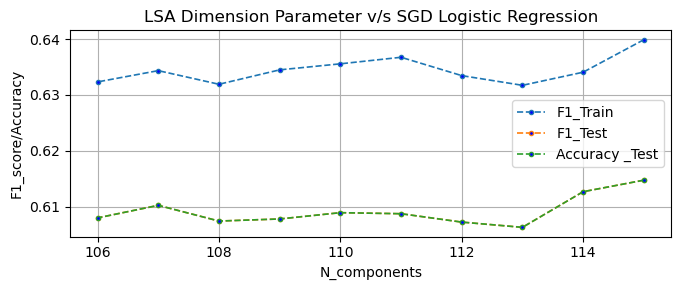

,N,F1_Train,F1_Test,Accuracy _Test
0,115,0.639895,0.614751,0.614751


In [54]:
kwargs = dict (linestyle='dashed', linewidth=1.2,marker='o',
               markerfacecolor='blue', markersize=3)
line_plot= svd_dm.plot(x="N",figsize=(7,3),**kwargs)
line_plot.set_title('LSA Dimension Parameter v/s SGD Logistic Regression')
line_plot.grid()
line_plot.set_xlabel('N_components')
line_plot.set_ylabel('F1_score/Accuracy')
plt.show()
bestN= svd_dm[svd_dm.index==svd_dm['F1_Test'].argmax()]
bestN


In [55]:
##Try go with n_comp=115
lsa= make_pipeline(TruncatedSVD(n_components=115), Normalizer(copy=False))
XLSA= lsa.fit_transform(X_tfidf)

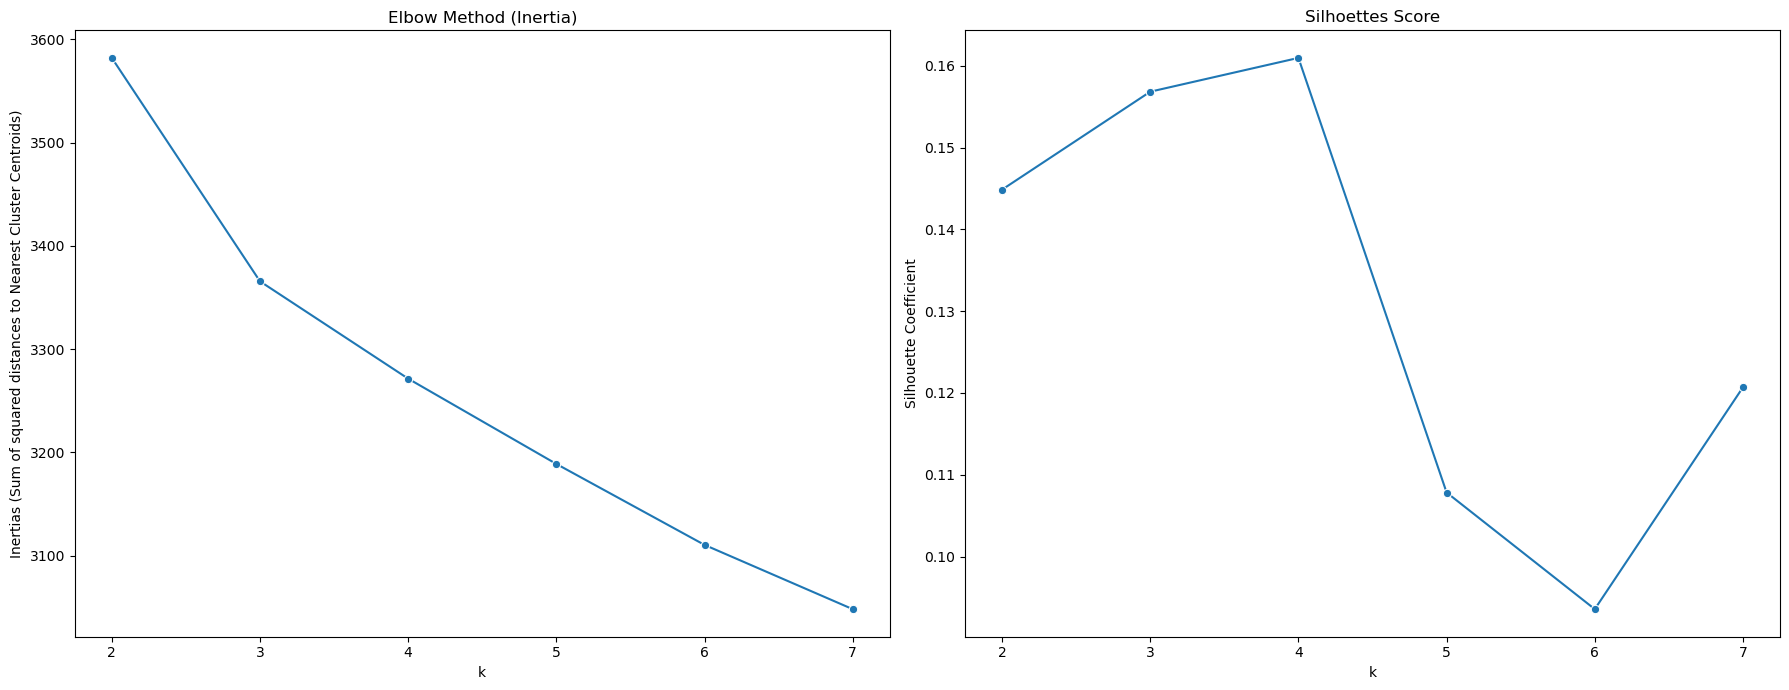

In [58]:
log = [] 
k_range = range(2,8) # Range of k values

for k in k_range:
    kmean = KMeans(n_clusters = k, random_state=961)
    clusterLabel = kmean.fit_predict(XLSA)
    inertia= kmean.inertia_
    centroids= kmean.cluster_centers_
    if True: # Generate Silhoettes Score
        silhoettes_avg = silhouette_score(XLSA, clusterLabel)
        log.append([k, inertia, silhoettes_avg])
        continue
    log.append([k, inertia])

plot_df = pd.DataFrame(
    log, columns = [
        'k', 'Inertias (Sum of squared distances to Nearest Cluster Centroids)', 'Silhouette Coefficient'
        ]
    )
fig, axes = plt.subplots(1,2, figsize=(18,7))
sns.lineplot(
    x='k', y='Inertias (Sum of squared distances to Nearest Cluster Centroids)', 
    data = plot_df, marker= 'o', ax = axes[0])
axes[0].set_title("Elbow Method (Inertia)")
sns.lineplot(x='k', y='Silhouette Coefficient', data=plot_df, marker='o', ax = axes[1])
axes[1].set_title("Silhoettes Score")
plt.show()

In [77]:
def silhouette_analysis_with_pca(n_clusters,X):
    
    # K-Mean Clustering
    kmean = KMeans(n_clusters = n_clusters, random_state=961)
    clusterLabel = kmean.fit_predict(X)
    centroids= kmean.cluster_centers_

    # Compute Individual Silhoette Score
    silhoettes_avg = silhouette_score(X, clusterLabel)

    # Compute Average Silhoette Score
    sample_silhouette_values = silhouette_samples(X, clusterLabel)
     # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ################################### Silhouette Plot #############################################
 
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_xlim([-0.1, 1])
    y_lower = 10

    # Assign colours for different cluster
    for i in range(n_clusters):
         # Aggregate the silhouette scores for samples belonging to
         # cluster i, and sort them
         ith_cluster_silhouette_values = sample_silhouette_values[clusterLabel == i]
         ith_cluster_silhouette_values.sort()
         size_cluster_i = ith_cluster_silhouette_values.shape[0]
         y_upper = y_lower + size_cluster_i
         color = cm.nipy_spectral(float(i) / n_clusters)
         ax1.fill_betweenx(np.arange(y_lower, y_upper),
                           0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.7)
         
         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
         y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette Plot for Clusters.")
    ax1.set_xlabel("Silhouette Coefficient Values")
    ax1.set_ylabel("Cluster Label")
    # avg sil score 
    ax1.axvline(x=silhoettes_avg, color="red", linestyle="--")
    ax1.set_yticks([]) 
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8])

    ################################### SVD Plot #############################################
 
    # Compute tsvd with only First 2 Number of Component
    tsvd2 = TruncatedSVD(n_components=2)
    sample2 = tsvd2.fit_transform(X)

    ##Getting diff color for diff cluster 
    colors = cm.nipy_spectral(clusterLabel.astype(float) / n_clusters)
    ax2.scatter(sample2[:,0], sample2[:,1], marker='.', s=70, lw=0, alpha=1,
            c=colors, edgecolor='k')

    centers = centroids.dot(tsvd2.components_.T) # Cluster Positions after transformation 
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                 c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of TSVD with total explained variance of {:.2f}%.".format(tsvd2.explained_variance_ratio_.sum()*100))
    ax2.set_xlabel("Feature space for the 1st component")
    ax2.set_ylabel("Feature space for the 2nd component")
    plt.suptitle(("Silhouette analysis for KMeans clustering on Toxic Comment Dataset"
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

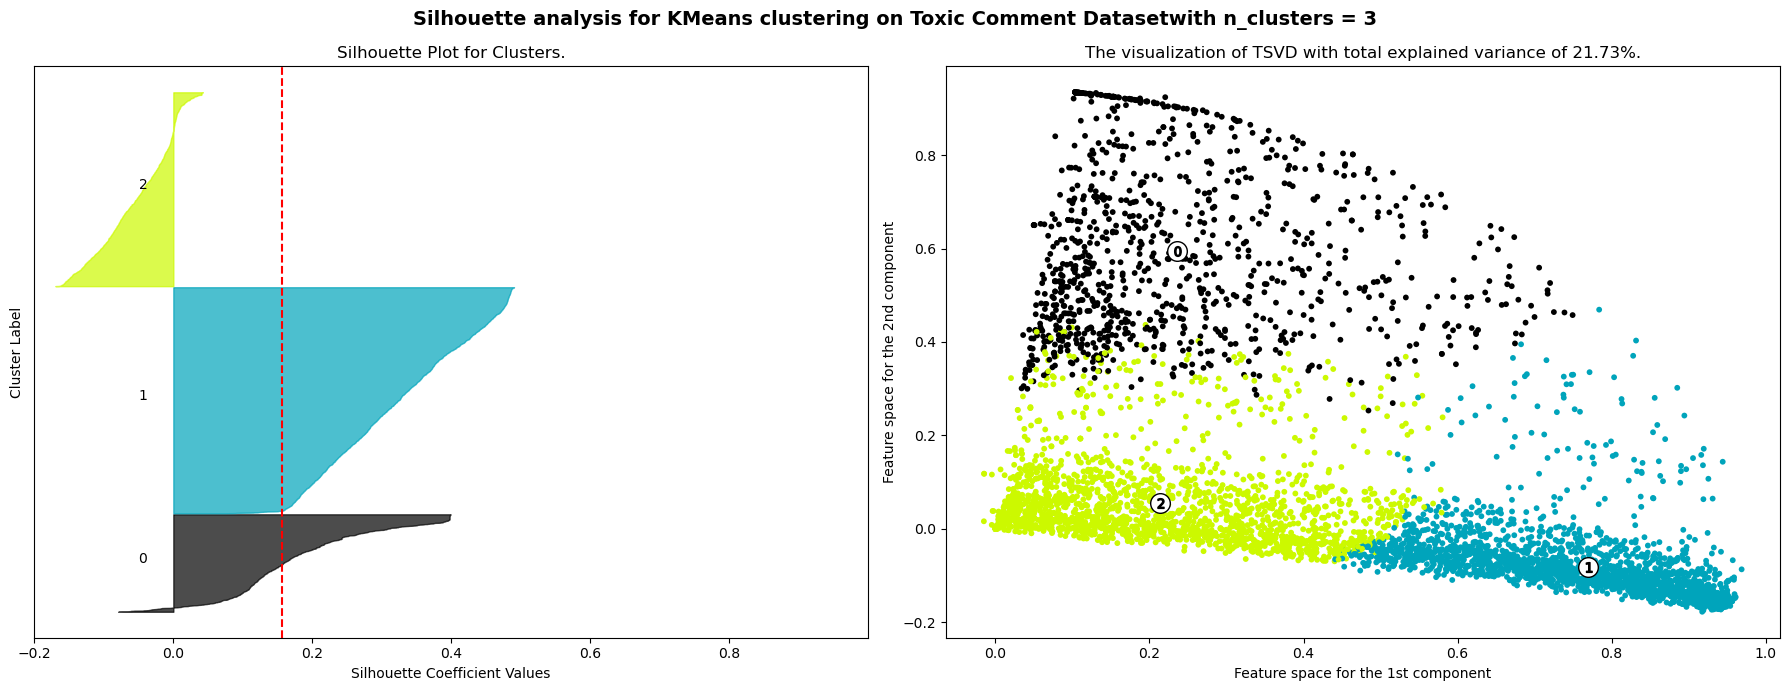

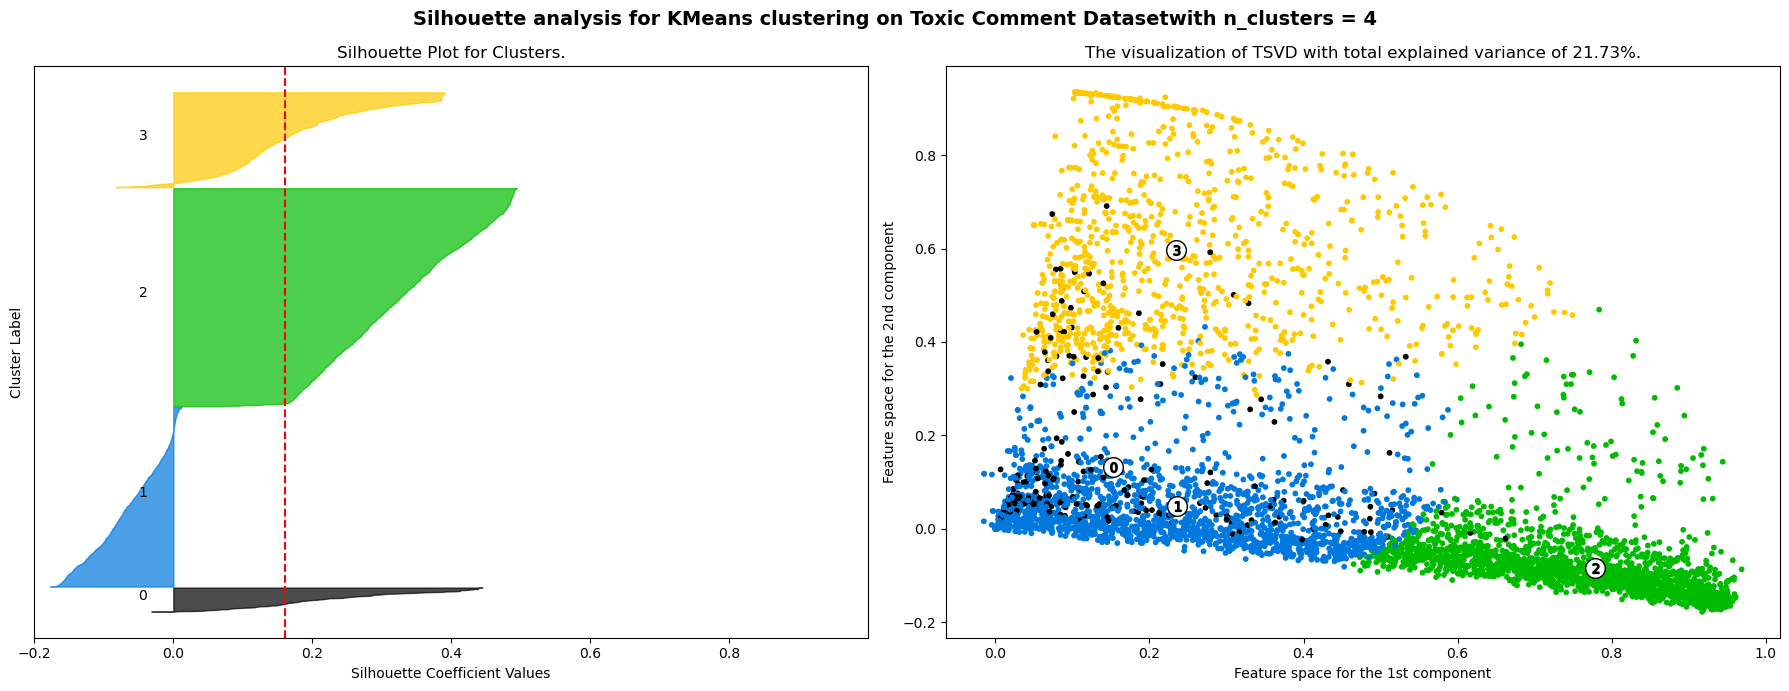

In [78]:
for i, k in enumerate(range(3,5)): # Analyse k = (3,4)
    silhouette_analysis_with_pca(n_clusters = k, X = XLSA)
    plt.show()